# Feature Engineering

This notebook will engineer text features from the property reviews, and temporal features from calendar data.  The text features will include the top BOW words from the preprocessed text, and cluster labels after text embedding.  (May need extra computing power).  The temporal features will be aggregated features like average price of neighbourhood by month.

In [10]:
# Read in libraries
# Load libraries
import numpy as np
import pandas as pd
import time
import os
import sys
import ast
import json
import random
import datetime as dt
from datetime import datetime
from itertools import chain
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.cluster import DBSCAN, KMeans
import string
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator
import langid

# Unlimited columns
pd.options.display.max_columns = None

In [50]:
# Read in data
# Load calendar data
calendar = pd.read_csv("../data/processed/calendar.csv")

# Load reviews data
#review_map = pd.read_csv("../data/raw/reviews_ids.csv")
reviews = pd.read_csv("../data/processed/reviews.csv")

# Load listings data
listings = pd.read_csv("../data/processed/listings.csv")

# Load neighborhoods
neighborhoods = pd.read_csv("../data/processed/neighbourhoods.csv")

In [51]:
# Functions
# Description:  Turn into BOW, and keep top n words OHE
def preprocess_text(text):
    """
    
    """
    
    stop_words = list(set(stopwords.words('english')))
    punctuation = string.punctuation
    stop_words += list(punctuation)
    stop_words.extend(['``','’', '`','br','"',"”", "''", "'s", "/b"]) 
    text = text.replace(r'<br />',' ')
    preprocessed = []    
        
    # Tokenization using nltk word tokenization
    tokenized = word_tokenize(text)
    for token in tokenized:
        token = token.lower()
        if token not in stop_words and len(token) > 1:
            preprocessed.append(token)
    return " ".join(preprocessed)

In [52]:
def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents,
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels
    
    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper left")

    plt.show()

## Review Feature Engineering

In [53]:
# Create smaller dataset for testing code
random.seed(42)
test_ids = random.sample(list(set(reviews.listing_id)), 100)
test_data = reviews.query("listing_id in @test_ids")

#### Remove empty string, remove extra characters

In [54]:
# Turn nan values into empty strings
test_data.comments.replace(np.nan, "", inplace=True)

# preprocess text
test_data.assign(comments = test_data.comments.apply(preprocess_text))

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:4506: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments
421,421,8142,8142,2014-09-08,8142,Stanton,excellent space clean quiet tenants friendly a...
422,422,8142,8142,2014-09-14,8142,Josh,perfect needed cheap place stay moving new pla...
423,423,8142,8142,2015-03-03,8142,Pame,aaron make us feel home best br/ thank much 'd...
424,424,8142,8142,2015-10-01,8142,José Luis,lo vi en la página web de airb br/
425,425,8142,8142,2015-11-01,8142,Rick,aaron nice helpful person hong kong enjoyed sp...
...,...,...,...,...,...,...,...
281379,281379,49502271,49502271,2021-07-02,49502271,Michael,stay marina wonderful location outstanding cle...
281388,281388,49516037,49516037,2021-05-16,49516037,Kris,parking destination fee included please carefu...
281389,281389,49516037,49516037,2021-05-25,49516037,Michael,easy stressless place stay incredibly close fi...
281390,281390,49516037,49516037,2021-06-05,49516037,Riley,awesome nights stay


## Translate to English

In [56]:
# Find the language of each comment
test_data['language_tuple'] = test_data.comments.apply(langid.classify)
test_data[['lang', 'cert']] = pd.DataFrame(test_data['language_tuple'].tolist(), index=test_data.index)
test_data.drop(['language_tuple', 'cert'], axis=1, inplace=True)

# Get non-English comments
non_english_comments = test_data.query("lang != 'en'").comments.tolist()

# tranlate the comments
non_english_comments = GoogleTranslator(source='auto', target='en').translate_batch(non_english_comments, )

# Replace the non-english comments with tranlated versioins
test_data.loc[test_data.lang != 'en', 'comments'] = non_english_comments

<ipython-input-56-b22ff8df854b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['language_tuple'] = test_data.comments.apply(langid.classify)


Please wait.. This may take a couple of seconds because deep_translator sleeps for two seconds after each request in order to not spam the google server.
sentence number  1  has been translated successfully
sentence number  2  has been translated successfully
sentence number  3  has been translated successfully
sentence number  4  has been translated successfully
sentence number  5  has been translated successfully
sentence number  6  has been translated successfully
sentence number  7  has been translated successfully
sentence number  8  has been translated successfully
sentence number  9  has been translated successfully
sentence number  10  has been translated successfully
sentence number  11  has been translated successfully
sentence number  12  has been translated successfully
sentence number  13  has been translated successfully
sentence number  14  has been translated successfully
sentence number  15  has been translated successfully
sentence number  16  has been translated succ

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### Add binary bow features for most common words in reviews

In [7]:
# BOW
# Create count vectorizer object.  Max features can be changed
desc_n = 15
vec = CountVectorizer(binary=True, max_features=desc_n)

# Fit count vectorizer
X_counts = vec.fit_transform(test_data.comments)

# Create new features
bow_df = pd.DataFrame(X_counts.toarray(), columns=["rev_" + str(col) for col in list(vec.vocabulary_.keys())], index=test_data.index)

# Add them onto the original dataframe
test_data = test_data.join(bow_df)

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:4506: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


#### Use NLTK's sentiment intensity analyzer to determine review sentiment.  Save score for pos, neg, neu.

In [9]:
# Sentiment Analysis
# https://www.nltk.org/howto/sentiment.html
sia = SentimentIntensityAnalyzer()

pos_scores = []
neg_scores = []
neu_scores = []
for rev in test_data.comments:
    pos_scores.append(sia.polarity_scores(rev)['pos'])
    neg_scores.append(sia.polarity_scores(rev)['neg'])
    neu_scores.append(sia.polarity_scores(rev)['neu'])
    
test_data = test_data.assign(rev_pos_score = pos_scores, 
                 rev_neg_score = neg_scores,
                 rev_neu_score = neu_scores)

#### Cluster reviews, one hot encode cluster assignments

In [30]:
embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [16]:
comment_data = test_data['comments'].tolist()
embeddings = embedder.encode(comment_data)
comment_embeddings = pd.DataFrame(
    embeddings,
    index=test_data.index,
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
421,-0.221751,0.063878,0.317759,-0.115290,0.349966,0.055786,0.192313,-0.354931,-0.036005,0.099297,0.138913,0.098372,-0.016604,0.425118,-0.152467,-0.162474,0.526092,0.517320,-0.171392,0.702598,0.117933,0.073020,-0.524322,-0.124747,0.391789,-0.268980,-0.258399,0.066463,-0.151630,-0.195203,0.121674,0.209447,-0.219979,-0.009230,-0.203465,0.301516,-0.015059,-0.237225,0.390483,-0.038368,-0.154899,0.434675,-0.227655,0.165083,-0.011395,-0.319678,-0.274594,-0.335029,0.097986,0.178535,-0.114139,0.070498,0.342732,-0.033442,-0.282474,0.568942,0.077238,-0.310202,-0.150123,0.741183,0.680284,-0.224760,-0.037348,0.062346,0.222461,0.146389,-0.047506,1.352706,0.237382,0.684606,0.210035,0.490489,-0.217570,0.525947,0.015280,0.802711,-0.427601,0.227227,-0.834246,0.106127,-0.284282,-0.244755,0.185526,-0.145607,-0.317893,0.119519,-0.151937,-0.492598,-0.203966,0.156811,0.115391,-0.327643,-0.444532,-0.621494,0.110549,0.033812,0.006374,-0.515094,0.135428,0.557372,0.141472,-0.288191,0.313802,0.092233,0.211567,-0.098140,-0.221158,-0.377265,0.087023,

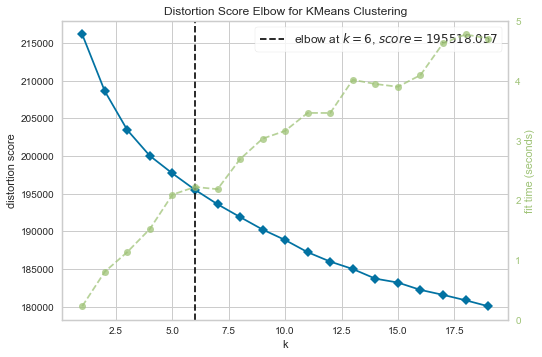

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(comment_embeddings)  # Fit the data to the visualizer
visualizer.show();

In [27]:
np.random.seed(42)
km_labels_dict = {
    k: KMeans(k).fit(comment_embeddings).predict(comment_embeddings) for k in np.arange(2, 7)
}

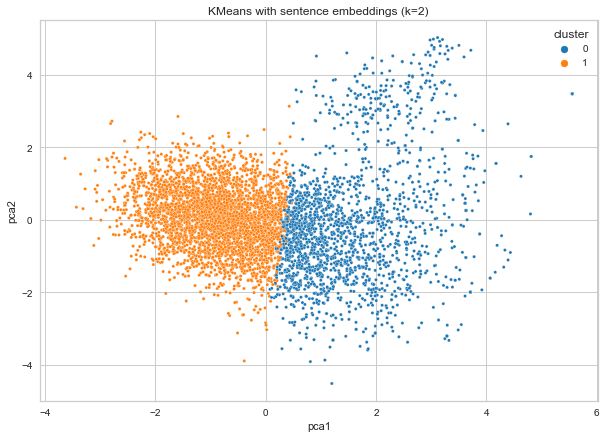

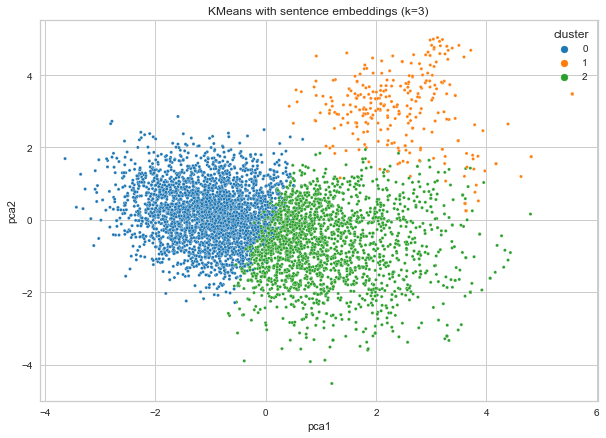

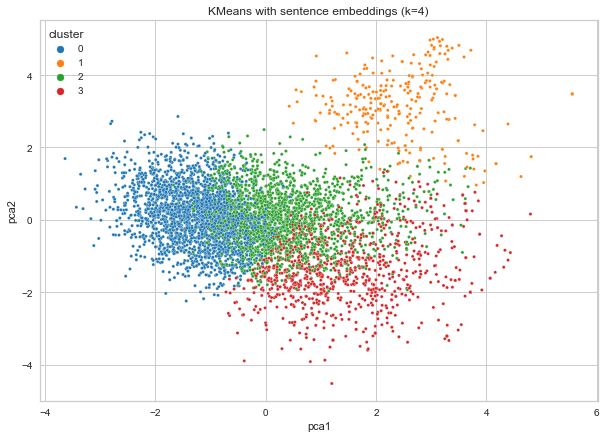

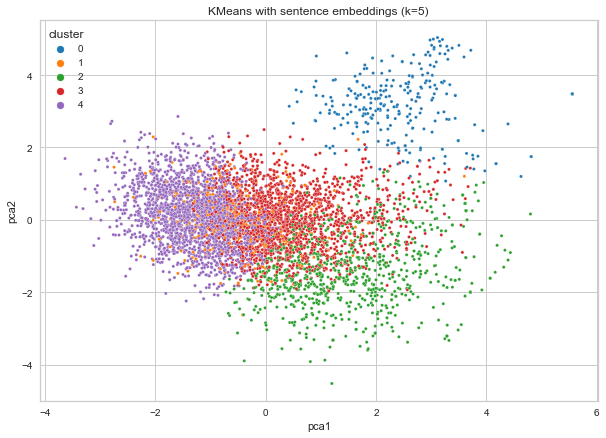

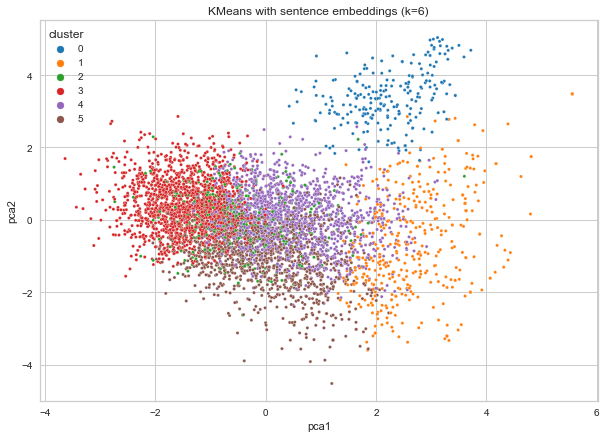

In [29]:
for k, labels in km_labels_dict.items():
    plot_pca_clusters(
        comment_embeddings,
        labels,
        test_data['comments'],
        size=10,
        title="KMeans with sentence embeddings (k=%d)" % (k),
    )

In [39]:
# Clustering
k = 6
test_data['review_cluster'] = km_labels_dict[k]

In [50]:
test_data.groupby('review_cluster').sample(5)

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,rev_clean,rev_place,rev_stay,rev_would,rev_nice,rev_great,rev_easy,rev_br,rev_host,rev_san,rev_location,rev_everything,rev_comfortable,rev_recommend,rev_room,rev_pos_score,rev_neg_score,rev_neu_score,review_cluster
219178,219178,21068061,21068061,2019-11-27,21068061,Youngchan,가족들 쉬고 갑니다,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,1.000,0
183552,183552,15051965,15051965,2017-03-27,15051965,Sylvie,hote discret et present la demande un peu exce...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.073,0.927,0
424,424,8142,8142,2015-10-01,8142,José Luis,lo vi en la página web de airb br/,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,1.000,0
186975,186975,15579415,15579415,2017-05-12,15579415,Kate,местоположение отличное для тех кто на машине ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,1.000,0
267183,267183,35809668,35809668,2019-09-09,35809668,Esther,alojamiento pequeño pero acogedor muy limpio e...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,1.000,0
73349,73349,2314849,2314849,2020-12-21,2314849,Dominic,lovely place,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.792,0.000,0.208,1
203697,203697,18140914,18140914,2021-06-24,18140914,Andrey,enjoyed stay,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.767,0.000,0.233,1
230631,230631,23147212,23147212,2019-06-23,23147212,Peter,great location enjoyed stay,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0.787,0.000,0.213,1
97254,97254,4372435,4372435,2019-08-20,4372435,Kaylee,definitely stay,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.730,0.000,0.270,1
263046,263046,33999573,33999573,2020-10-21,33999573,Julie,comfy bed amazing shower great location,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.664,0.000,0.336,1


In [47]:
import langid
langid.classify("This is a test")[0]

'en'

In [ ]:
# Add new features

## Calendar Feature Engineering

In [15]:
# Merge neighbourhood data onto calendar data
calendar.head()

,Unnamed: 0,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,0,130805,2021-04-08,0,97.0,97.0,30.0,90.0
1,1,12042,2021-04-08,1,65.0,65.0,32.0,90.0
2,2,958,2021-04-10,0,150.0,150.0,2.0,1125.0
3,3,958,2021-04-11,0,150.0,150.0,2.0,1125.0
4,4,958,2021-04-12,1,151.0,151.0,2.0,1125.0


In [ ]:
# Add day of week feature

In [ ]:
# Add week of year feature

In [ ]:
# Add month of year feature

In [ ]:
# Add year feature

In [ ]:
# Add binary holiday feature

In [ ]:
# Aggregate price by day, week, month, year and neighborhood

## Listings Feature Engineering

In [16]:
listings.head()

,Unnamed: 0,id,description,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,desc_apartment,desc_located,desc_space,desc_home,desc_bed,desc_room,desc_kitchen,desc_access,desc_one,desc_private,desc_san,desc_francisco,desc_bathroom,desc_bedroom,desc_living,host_in_sf,host_verifications_None,host_verifications_email,host_verifications_facebook,host_verifications_google,host_verifications_government_id,host_verifications_identity_manual,host_verifications_jumio,host_verifications_kba,host_verifications_manual_offline,host_verifications_manual_online,host_verifications_offline_government_id,host_verifications_phone,host_verifications_reviews,host_verifications_selfie,host_verifications_sent_id,host_verifications_work_email,host_verifications_zhima_selfie,bathroom_private,bathroom_shared,bathroom_half,bathroom_count,amenities_Wifi,amenities_Smoke alarm,amenities_Essentials,amenities_Heating,amenities_Hangers,amenities_Carbon monoxide alarm,amenities_Hair dryer,amenities_Long term stays allowed,amenities_Iron,amenities_TV,amenities_Kitchen,amenities_Shampoo,amenities_Dedicated workspace,amenities_Hot water,amenities_Washer,amenities_Dryer,amenities_Fire extinguisher,amenities_Refrigerator,amenities_Coffee maker,amenities_Microwave,amenities_Dishes and silverware,amenities_Bed linens,amenities_First aid kit,amenities_Cooking basics,amenities_Private entrance,amenities_Oven,amenities_Free street parking,amenities_Stove,amenities_Dishwasher,amenities_Extra pillows and blankets,review_span,t_since_last_review,t_as_host,has_license
0,0,958,please check local laws covid request reservat...,1169,"San Francisco, California, United States",within an hour,1.0,0.91,1.0,Other,1.0,1.0,1.0,1.0,Western Addition,NaN,37.77028,-122.43317,Entire apartment,Entire home/apt,3,1 bath,1.0,2.0,150.0,2,30,2.0,2.0,1125.0,1125.0,2.0,1125.0,1,4,6,10,112,277,36,1,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,1,0,0,1.94,2,2,0,2,0,0,1,1,0,1,0,0,2,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.0,0.0,0.0,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,4274.0,112.0,4743.0,1
1,1,5858,space live large victorian house quiet street ...,8904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bernal Heights,NaN,37.74474,-122.42089,Entire apartment,Entire home/apt,5,1 bath,2.0,3.0,195.0,30,60,30.0,30.0,60.0,60.0,30.0,60.0,1,30,60,90,365,111,0,0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1,1,0,0,0.76,1,0,0,0,0,0,0,2,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,3017.0,1450.0,NaN,0
2,2,7918,nice good public transportation minutes walk u...,21994,"San Francisco, California, United States",NaN,NaN,NaN,0.0,Other,10.0,10.0,1.0,1.0,Haight Ashbury,NaN,37.76555,-122.45213,Private room in apartment,Private room,2,4 shared baths,1.0,1.0,56.0,32,60,32.0,32.0,60.0,60.0,32.0,60.0,1,30,60,90,365,19,0,0,84.0,7.0,8.0,9.0,9.0,9.0,8.0,0,8,0,8,0,0.13,0,1,0,1,0,0,0,1,0,1,0,3,6,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0.0,1.0,0.0,4.0,1,1,0,1,1,1,0,1,0,1,1,0,0,1,1,1,1,0,0,0,0,

In [17]:
# OHE the description and pull the top n words

In [ ]:
# 

## Create the Modeling Data